In [73]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Tuple

In [74]:
def calculate_distance(nodes, node1, node2) -> int:
    x1, y1, _ = nodes[node1]
    x2, y2, _ = nodes[node2]
    return round(math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))

In [75]:
def create_distance_matrix(nodes) -> np.ndarray:
    matrix = np.zeros(shape=(len(nodes), len(nodes)), dtype=np.int32)
    for node_index_1 in range(len(nodes) - 1):
        for node_index_2 in range(node_index_1 + 1, len(nodes)):
            distance = calculate_distance(nodes, node_index_1, node_index_2)
            matrix[node_index_1, node_index_2] = distance
            matrix[node_index_2, node_index_1] = distance
            matrix[node_index_1, node_index_2] += nodes[node_index_2][2]
            matrix[node_index_2, node_index_1] += nodes[node_index_1][2]
    return matrix

In [76]:
def evaluate(distance_matrix: np.ndarray, path: list, costs: list) -> int:
    total_length = 0
    for i in range(len(path) - 1):
        total_length += distance_matrix[path[i], path[i + 1]]
    score = total_length
    return score

In [77]:
def random_solution(distance_matrix: np.ndarray, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = n // 2 if n % 2 == 0 else (n // 2) + 1
    path = random.sample(list(range(distance_matrix.shape[0])), num_selected)

    path = path + [path[0]]

    return path

In [78]:
def nearest_neighbor(distance_matrix: np.ndarray, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = n // 2 if n % 2 == 0 else (n // 2) + 1

    max_distance = 2147483647

    distance_matrix_copy = distance_matrix.copy()

    current_node_index = start_node

    for index in range(distance_matrix.shape[0]):
        distance_matrix_copy[index, index] = max_distance

    path = [current_node_index]

    while len(path) < num_selected:

        current_node_distances = distance_matrix_copy[current_node_index, :]
        closest_node_index = np.argmin(current_node_distances)

        distance_matrix_copy[current_node_index, :] = max_distance
        distance_matrix_copy[:, current_node_index] = max_distance

        path.append(closest_node_index)
        current_node_index = closest_node_index

    path = path + [path[0]]

    return path

In [79]:
def greedy_cycle(distance_matrix: np.ndarray, start_node: int = 0) -> List[int]:
    max_distance = 2147483647
    for index in range(distance_matrix.shape[0]):
        distance_matrix[index, index] = max_distance
    second_node = np.argmin(distance_matrix[start_node,:])
    path = [start_node, second_node]
    target_length = math.ceil(len(distance_matrix)/2)
    free_nodes = list(range(distance_matrix.shape[0]))
    free_nodes.remove(start_node)
    free_nodes.remove(second_node)
    d = np.full(distance_matrix.shape, float('inf'))
    for node in free_nodes:
        d[start_node, node] = distance_matrix[start_node, node] \
                            + distance_matrix[second_node, node] \
                            - distance_matrix[start_node, second_node]
        d[second_node, node] = d[start_node, node]
    while len(path) < target_length:
        for node in path:
            d[:,node] = float('inf')
        prev_node, new_node = np.argwhere(d == np.min(d)).tolist()[0]
        pos = path.index(prev_node)
        free_nodes.remove(new_node)
        if pos == len(path)-1:
            next_node = path[0]
        else:
            next_node = path[pos+1]
        path.insert(pos+1, new_node)
        for node in free_nodes:
            d[new_node, node] = distance_matrix[new_node, node] \
                              + distance_matrix[node, next_node] \
                              - distance_matrix[new_node, next_node]
    return path + [path[0]]

In [80]:
def get_plot_values(nodes : Dict[int, Tuple[int, int, int]], solution: List[int], costs: List[int]) -> Tuple[List[int], List[int], List[int], List[int], List[int]]:
    x_coords = [nodes[node][0] for node in list(nodes.keys())]
    y_coords = [nodes[node][1] for node in list(nodes.keys())]
    path_x_coords = [nodes[node][0] for node in solution]
    path_y_coords = [nodes[node][1] for node in solution]

    costs = [(cost/max(costs))*100 for cost in costs]
    return x_coords, y_coords, costs, path_x_coords, path_y_coords

In [81]:
def run_experiment(nodes: Dict[int, Tuple[int, int, int]], distance_matrix: np.ndarray, costs: List[int]) -> None:
  function_mapping = {
      'random' : random_solution,
      'nearest neighbour' : nearest_neighbor,
      'greedy_cycle' : greedy_cycle
  }

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  i = 0
  for function_name in list(function_mapping.keys()):
    function = function_mapping[function_name]
    solutions = [function(distance_matrix, starting_node) for starting_node in range(distance_matrix.shape[0])]
    solution_scores = [evaluate(distance_matrix, solution, costs) for solution in solutions]
    best_solution = solutions[solution_scores.index(min(solution_scores))]
    min_objective = min(solution_scores)
    max_objective = max(solution_scores)
    average_objective = sum(solution_scores) / len(solution_scores)
    print(f'\n{function_name} results:\n')
    print("Max score:", max_objective)
    print("Average score:", average_objective)
    print("Min/Best score:", min_objective)
    print("Selected Nodes:", best_solution)
    x_coords, y_coords, costs, path_x_coords, path_y_coords = get_plot_values(nodes, best_solution, costs)
    axes[i].scatter(x_coords, y_coords, color='red', marker='o', s=costs, label='Cities')
    axes[i].plot(path_x_coords, path_y_coords, linestyle='-', marker='o', markersize=5, color='blue', label='Path')
    axes[i].set_xlabel('X Coordinate')
    axes[i].set_ylabel('Y Coordinate')
    axes[i].set_title(f"Best {function_name} solution")
    i += 1


In [82]:
def get_solution(filename: str) -> None:
  df = pd.read_csv(filename, names=["x", "y", "cost"], sep=';', header=None)
  print(f'Instance: {filename}')
  nodes = {}
  costs = []
  for idx, row in enumerate(df.values):
      x, y, cost = map(int, row)
      costs.append(cost)
      nodes[idx] = (x, y, cost)
  costs = [nodes[node][2] for node in list(nodes.keys())]
  distance_matrix = create_distance_matrix(nodes)
  run_experiment(nodes, distance_matrix, costs)


Instance: TSPA.csv

random results:

Max score: 289753
Average score: 265239.275
Min/Best score: 239469
Selected Nodes: [133, 105, 66, 110, 103, 20, 76, 96, 39, 7, 55, 81, 190, 122, 84, 67, 196, 9, 34, 85, 186, 30, 79, 173, 120, 199, 194, 144, 134, 31, 73, 54, 138, 146, 142, 3, 70, 56, 69, 181, 139, 112, 197, 184, 64, 171, 147, 58, 178, 153, 192, 193, 16, 108, 159, 195, 113, 132, 151, 52, 114, 4, 167, 60, 17, 88, 0, 89, 182, 106, 145, 38, 160, 130, 162, 26, 121, 14, 74, 15, 176, 86, 95, 62, 143, 163, 49, 172, 94, 136, 158, 41, 124, 47, 119, 185, 59, 152, 92, 48, 133]

nearest neighbour results:

Max score: 95013
Average score: 87679.135
Min/Best score: 84471
Selected Nodes: [1, 177, 75, 189, 119, 48, 106, 11, 152, 130, 26, 8, 95, 169, 135, 167, 186, 79, 141, 6, 98, 66, 72, 94, 31, 80, 14, 111, 73, 112, 51, 190, 156, 172, 24, 87, 154, 81, 117, 55, 195, 74, 163, 113, 185, 96, 147, 59, 143, 178, 19, 0, 149, 114, 4, 77, 43, 50, 121, 91, 76, 22, 53, 62, 108, 171, 21, 194, 144, 102, 133, 180

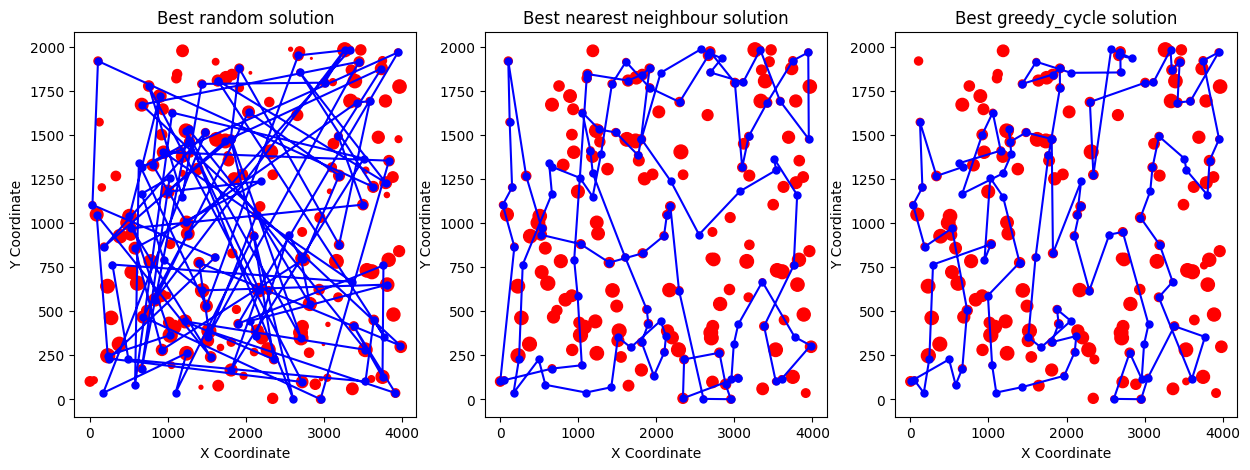

In [83]:
get_solution('TSPA.csv')

Instance: TSPB.csv

random results:

Max score: 290078
Average score: 266214.395
Min/Best score: 239291
Selected Nodes: [186, 182, 120, 16, 50, 130, 183, 155, 61, 134, 160, 29, 47, 104, 30, 174, 168, 116, 71, 91, 3, 22, 57, 117, 115, 92, 169, 96, 77, 127, 32, 89, 159, 52, 188, 83, 150, 75, 103, 194, 8, 0, 142, 82, 141, 153, 27, 40, 147, 34, 198, 79, 38, 6, 128, 175, 126, 21, 87, 58, 111, 80, 53, 94, 185, 44, 106, 63, 48, 86, 196, 69, 107, 197, 5, 156, 179, 190, 163, 114, 7, 132, 76, 192, 148, 144, 176, 90, 81, 73, 129, 10, 177, 135, 31, 133, 36, 145, 161, 173, 186]

nearest neighbour results:

Max score: 82631
Average score: 79282.58
Min/Best score: 77448
Selected Nodes: [63, 82, 115, 8, 16, 18, 12, 132, 185, 73, 136, 145, 80, 88, 153, 137, 99, 66, 143, 179, 101, 31, 34, 183, 197, 127, 121, 24, 103, 38, 131, 50, 154, 25, 36, 134, 165, 37, 157, 190, 135, 198, 19, 33, 29, 52, 44, 117, 196, 142, 148, 141, 130, 140, 174, 91, 51, 70, 67, 114, 162, 150, 71, 119, 59, 64, 129, 89, 159, 147, 18

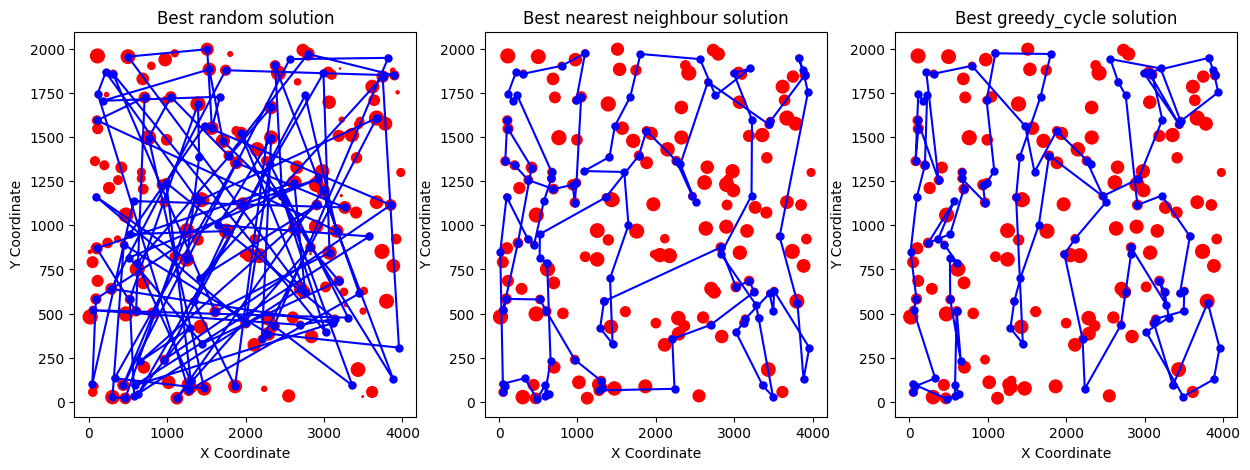

In [84]:
get_solution('TSPB.csv')

Instance: TSPC.csv

random results:

Max score: 236957
Average score: 214666.525
Min/Best score: 192326
Selected Nodes: [12, 96, 65, 184, 140, 102, 44, 53, 121, 98, 68, 47, 104, 109, 82, 182, 126, 160, 8, 142, 175, 91, 191, 89, 31, 87, 78, 168, 51, 37, 1, 50, 66, 189, 88, 97, 186, 132, 195, 174, 101, 161, 152, 148, 164, 99, 72, 192, 45, 133, 30, 9, 35, 181, 64, 157, 153, 39, 57, 27, 112, 130, 75, 196, 2, 29, 149, 33, 5, 146, 6, 62, 94, 95, 183, 114, 122, 150, 136, 147, 15, 127, 7, 119, 162, 34, 154, 128, 17, 54, 163, 76, 173, 169, 83, 58, 61, 171, 19, 144, 12]

nearest neighbour results:

Max score: 63697
Average score: 58872.68
Min/Best score: 56304
Selected Nodes: [190, 98, 6, 66, 156, 172, 141, 87, 79, 21, 194, 186, 88, 153, 114, 4, 77, 43, 149, 0, 19, 178, 164, 128, 132, 55, 195, 22, 117, 53, 62, 74, 163, 113, 185, 64, 20, 71, 61, 183, 103, 7, 32, 180, 81, 154, 144, 102, 133, 171, 108, 15, 18, 155, 93, 146, 182, 138, 36, 76, 161, 91, 121, 50, 69, 35, 86, 192, 199, 177, 75, 189, 1, 

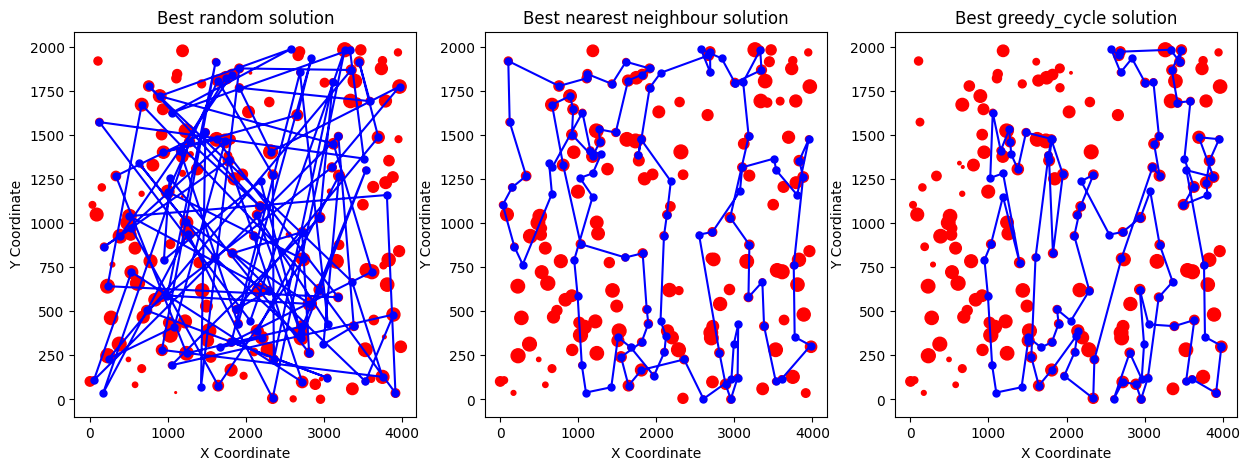

In [85]:
get_solution('TSPC.csv')

Instance: TSPD.csv

random results:

Max score: 238413
Average score: 219747.945
Min/Best score: 192691
Selected Nodes: [92, 15, 74, 122, 125, 87, 119, 115, 71, 58, 164, 28, 130, 187, 190, 175, 46, 136, 10, 47, 81, 173, 105, 121, 52, 147, 40, 48, 89, 54, 23, 25, 177, 65, 156, 142, 198, 168, 0, 191, 96, 159, 192, 63, 68, 41, 94, 124, 29, 129, 188, 70, 158, 186, 30, 67, 145, 32, 85, 116, 109, 22, 155, 44, 88, 73, 180, 153, 39, 182, 69, 169, 26, 34, 27, 133, 43, 127, 42, 103, 120, 184, 14, 166, 178, 3, 176, 102, 132, 6, 113, 35, 66, 110, 64, 61, 7, 185, 135, 197, 92]

nearest neighbour results:

Max score: 59846
Average score: 54290.68
Min/Best score: 50335
Selected Nodes: [12, 107, 139, 44, 117, 196, 150, 162, 67, 114, 85, 129, 64, 89, 159, 147, 58, 171, 72, 71, 119, 59, 193, 166, 28, 110, 158, 156, 91, 51, 70, 174, 140, 148, 141, 142, 130, 188, 161, 192, 21, 138, 82, 115, 8, 63, 16, 18, 132, 185, 73, 136, 61, 33, 29, 190, 135, 198, 66, 169, 99, 137, 88, 153, 80, 157, 145, 79, 19, 95, 17

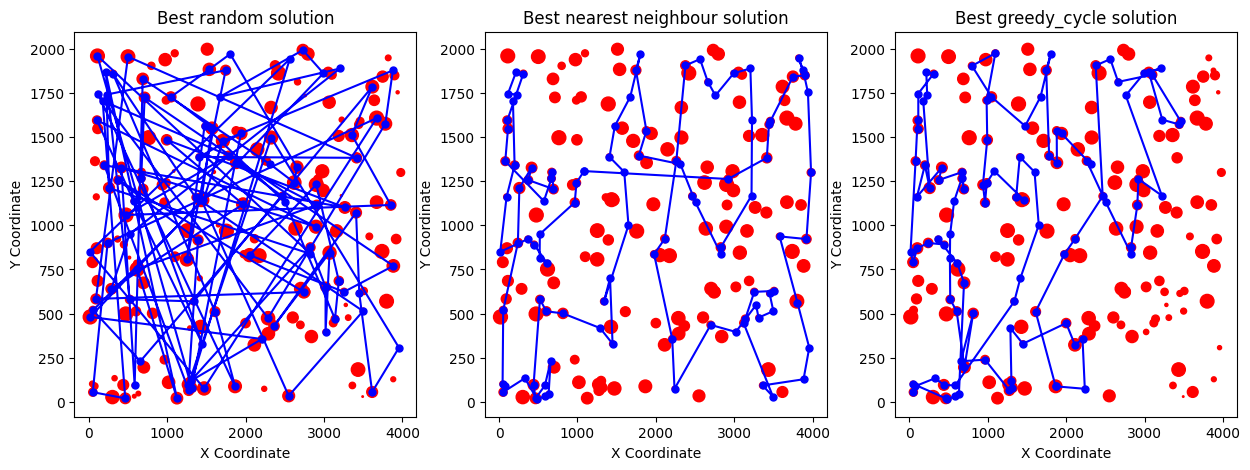

In [86]:
get_solution('TSPD.csv')